In [1]:
import pandas as pd
import numpy as np
import os
import glob
import cv2
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications.inception_v3 import InceptionV3
from keras.applications import inception_v3
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
import tensorflow.keras.optimizers
from keras.preprocessing.image import array_to_img, img_to_array, load_img
import tensorflow.image
from google.colab import drive
from tqdm import tqdm
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, \
                                    Add, AveragePooling2D, Flatten, Dense, Dropout, Activation,MaxPooling2D, Resizing
import tensorflow.keras.layers as layers
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.datasets import cifar100
from skimage.transform import resize
from keras.utils import np_utils

In [2]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# بخش ب و ج

## پیاده سازی شبکه

In [31]:
base_model =                    InceptionV3(weights='imagenet', 
                                include_top=True)

## پیش بینی عکس محیط اطراف

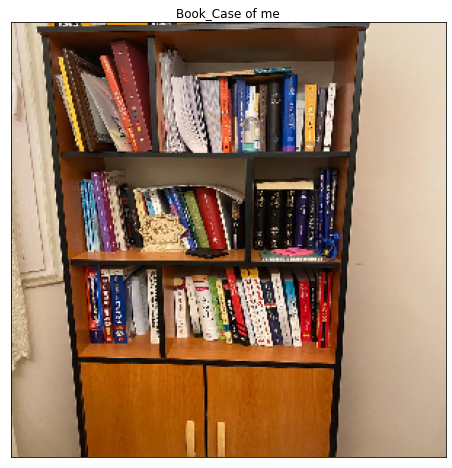

In [54]:
img = image.load_img('./test1.jpeg', target_size=(299, 299))
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img);
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Book_Case of me")
img = img_to_array(img)
img = preprocess_input(img)
img = np.expand_dims(img, axis=0)

In [55]:
prediction = base_model.predict(img)
top3 = inception_v3.decode_predictions(prediction, top=3)
top3

[[('n02870880', 'bookcase', 0.98159903),
  ('n03661043', 'library', 0.0022117575),
  ('n06596364', 'comic_book', 0.002135228)]]

WE cam see the predictions of inception are wonderful as expected

# بخش د و ه

In [14]:
#Loading cifar100
(X_train, y_train), (X_test, y_test) = cifar100.load_data()
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


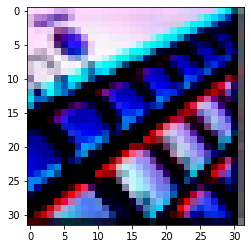

In [42]:
plt.imshow(X_train[200])

In [5]:
prediction = base_model.predict(np.expand_dims(resize(X_train[200], (299, 299)), axis=0))
top3 = inception_v3.decode_predictions(prediction, top=3)
top3

[[('n03485407', 'hand-held_computer', 0.10203937),
  ('n03884397', 'panpipe', 0.09438219),
  ('n02666196', 'abacus', 0.09035446)]]

WE can see predictions are wrong

In [15]:
## Getting two classes of keyboard and mouse from cifar100 and resizing them to (299, 299, 3) and labeling them as 0 and 1 resectively


index1 = np.where(y_train==39)[0]
index2 = np.where(y_train==50)[0]
index = np.concatenate((index1, index2))
X_train = X_train[index]
y_train = y_train[index]
ind1 = np.where(y_train==39)[0]
y_train[ind1] = 0
ind2 = np.where(y_train==50)[0]
y_train[ind2] = 1
index3 = np.where(y_test==39)[0]
index4 = np.where(y_test==50)[0]
index5 = np.concatenate((index3, index4))
X_test = X_test[index5]
y_test = y_test[index5]
ind1 = np.where(y_test==39)[0]
y_test[ind1] = 0
ind2 = np.where(y_test==50)[0]
y_test[ind2] = 1

#Label Encoding
y_train = np_utils.to_categorical(y_train, 2)
y_test = np_utils.to_categorical(y_test, 2)


X_n  = np.zeros((X_train.shape[0], 299, 299, 3))
X_t = np.zeros((X_test.shape[0], 299, 299, 3))
for i in range(X_train.shape[0]):
  X_n[i] = np.expand_dims(resize(X_train[i], (299, 299)), axis=0)
for i in range(X_test.shape[0]):
  X_t[i] = np.expand_dims(resize(X_test[i], (299, 299)), axis=0)

## Solving the problem of main model

In order to solve the problem of main model we remove the last dense fc layer of inception and replace it with a 2 neuron dence fc layer of our own with softmax activation function while keeping the main weights of inception and only training the weights of our newly added fc layer

In [16]:
modified_model =                InceptionV3(weights='imagenet', 
                                include_top=False,
                                input_shape=(299, 299,3))
modified_model.trainable = False

In [21]:
model = Sequential()
model.add(modified_model)
model.add(Flatten())
model.add(Dense(2, activation = 'softmax'))

In [22]:
model.compile(optimizer = tensorflow.keras.optimizers.Adam(0.001), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])
history = model.fit(X_n, y_train, batch_size = 64, epochs= 8, validation_data = (X_t, y_test))

Epoch 1/8
16/16 [==============================] - 17s 716ms/step - loss: 0.5265 - acc: 0.9050 - val_loss: 1.0547 - val_acc: 0.9600
Epoch 2/8
16/16 [==============================] - 9s 591ms/step - loss: 0.2206 - acc: 0.9860 - val_loss: 0.2412 - val_acc: 0.9900
Epoch 3/8
16/16 [==============================] - 9s 589ms/step - loss: 0.0732 - acc: 0.9970 - val_loss: 0.3485 - val_acc: 0.9850
Epoch 4/8
16/16 [==============================] - 9s 591ms/step - loss: 0.0052 - acc: 0.9990 - val_loss: 0.2991 - val_acc: 0.9850
Epoch 5/8
16/16 [==============================] - 10s 657ms/step - loss: 1.5341e-07 - acc: 1.0000 - val_loss: 0.4106 - val_acc: 0.9800
Epoch 6/8
16/16 [==============================] - 9s 596ms/step - loss: 3.5174e-07 - acc: 1.0000 - val_loss: 0.4418 - val_acc: 0.9750
Epoch 7/8
16/16 [==============================] - 9s 595ms/step - loss: 9.1185e-07 - acc: 1.0000 - val_loss: 0.4481 - val_acc: 0.9750
Epoch 8/8
16/16 [==============================] - 9s 592ms/step - lo

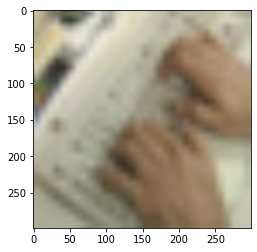

In [48]:
plt.imshow(X_t[10])

In [49]:
prediction = base_model.predict(np.expand_dims(resize(X_t[10], (299, 299)), axis=0))
top3 = inception_v3.decode_predictions(prediction, top=3)
top3

[[('n03476991', 'hair_spray', 0.38253075),
  ('n03825788', 'nipple', 0.16213036),
  ('n04357314', 'sunscreen', 0.05326056)]]

In [52]:
pred = model.predict(np.expand_dims(X_t[10],axis=0))
pred

array([[0.92616236, 0.07383765]], dtype=float32)

We can see that beacuse of strong feature extraction of inception only in 3 epoches we get 100 accuracy on training data and as shown in above for a keyboard the base model predicts a hair spray with prob of 0.38 while our newly trained model predicts a keyboard with prob of 0.93 and that's how we solve the problem

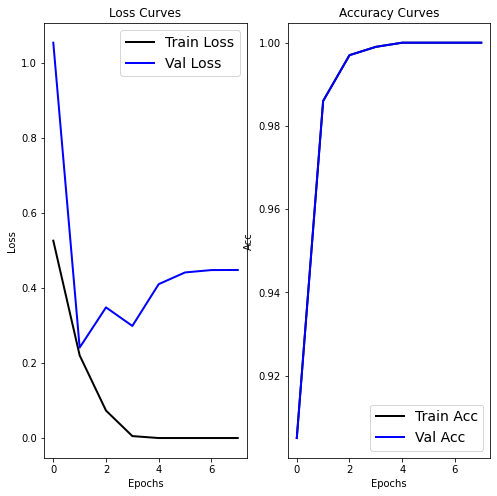

In [23]:
fig, ax = plt.subplots(nrows = 1, ncols = 2,figsize = (8, 8))
ax[0].plot(history.history['loss'], 'black', linewidth=2.0)
ax[0].plot(history.history['val_loss'], 'blue', linewidth=2.0)
ax[0].legend(['Train Loss', 'Val Loss'], fontsize=14)
ax[0].set(xlabel= 'Epochs'
            , ylabel= 'Loss'
            , title= 'Loss Curves');
ax[1].plot(history.history['acc'], 'black', linewidth=2.0)
ax[1].plot(history.history['acc'], 'blue', linewidth=2.0)
ax[1].legend(['Train Acc', 'Val Acc'], fontsize=14)
ax[1].set(xlabel= 'Epochs'
            , ylabel= 'Acc'
            , title= 'Accuracy Curves');
